### Student Information
Name: **Supakarn Jariyayong**

Student ID: **111065431**

GitHub ID: **supakarn-j**

Kaggle name: **Supakarn Jariyayong**

Kaggle private scoreboard snapshot:

![Snapshot](pics/leaderboard.png)

# Kaggle Report

This is a report for kaggle competition.  

<u>***Goal***</u>: Predict emotion from twitter post

In this notebook contains

1. Data preparation
   - Load data
   - Sampling
2. Pre-processing
   - Data cleaning
   - Data segmentation
3. Feature extraction
   - BOW
   - TFIDF
4. Train Model &  Classification
   - BOW + Multinomial Naive Bayes
   - BOW + Logistic Regression
   - TFIDF + Multinomial Naive Bayes
   - TFIDF + Logistic Regression
   - RoBERTa
5. Conclusion
   - Findings
   - What I want to try
   - What I want to improve

## 1. Data Preparation

### Loading data

In [3]:
import numpy as np
import pandas as pd
import json

## Load data
iden = pd.read_csv("datasets/data_identification.csv")
emo = pd.read_csv("datasets/emotion.csv")
raw =  pd.read_json('datasets/tweets_DM.json', lines=True)

## flatten nested json data to get tweet_id and text
data = pd.json_normalize(raw._source)

## extract only tweet_id and text
if 'tweet.hashtags' in list(data.columns):
    data.drop(['tweet.hashtags'],axis=1, inplace=True)
data.rename({'tweet.tweet_id':'tweet_id','tweet.text':'text'}, axis=1, inplace=True)

## merge data to get data identification (identify data as train or test)
data = data.merge(iden, how='inner')

## seperate train and test data from original data frame
x_test = data[data['identification'] == 'test']
x_train = data[data['identification'] == 'train']

## merge train data to get emotion label of each data in data set
x_train = x_train.merge(emo,how='inner',on=['tweet_id'])

## save data into pickle file format
x_test.drop(['identification'], axis=1).to_pickle("datasets/x_test.pkl")
x_train.drop(['identification'], axis=1).to_pickle("datasets/x_train.pkl")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

pd.get_option("display.max_colwidth")
pd.set_option("display.max_colwidth", None)
%matplotlib inline

## Load data from pickle
x_train = pd.read_pickle("datasets/x_train.pkl")
x_test = pd.read_pickle("datasets/x_test.pkl")

datas = [x_train, x_test]
names = ['x_train', 'x_test']
for i, n in zip(datas,names):
    i.drop(['hashtag'],axis=1, inplace=True)
    print('{}: {}'.format(n,i.shape))

x_train: (1455563, 3)
x_test: (411972, 2)


In [2]:
x_train

,tweet_id,text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be dehydrated. Cuz man.... that's <LH>",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy. #CNN",sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TIME tonight. What stories! Heartbreakingly <LH> #authentic #LaughOutLoud good!!,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...,...
1455558,0x321566,I'm SO HAPPY!!! #NoWonder the name of this show! #Happy! @HappySYFY @SYFY @Chris_Meloni 👏👏👏👏👏,joy
1455559,0x38959e,In every circumtance I'd like to be thankful to the Almighty Jesus Christ <LH>,joy
1455560,0x2cbca6,there's currently two girls walking around the library just handing out red bulls <LH> #blessyou,joy
1455561,0x24faed,"Ah, corporate life, where you can date <LH> using just the relative anachronism of the last job title that updated it.",joy


In [3]:
x_test

,tweet_id,text
2,0x28b412,"Confident of your obedience, I write to you, knowing that you will do even more than I ask. (Philemon 1:21) 3/4 #bibleverse <LH> <LH>"
4,0x2de201,"""Trust is not the same as faith. A friend is someone you trust. Putting faith in anyone is a mistake."" ~ Christopher Hitchens <LH> <LH>"
9,0x218443,When do you have enough ? When are you satisfied ? Is you goal really all about money ? #materialism #money #possessions <LH>
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #GodsWork <LH>"
33,0x26289a,"In these tough times, who do YOU turn to as your symbol of hope? <LH>"
...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from the beginning, that we should love one another."" I John 3:11 KJV <LH>"
1867529,0x2a980e,"""There is a lad here, which hath five barley loaves, and two small fishes: but what are they among so many?"" ~John 6:9 <LH>"
1867530,0x316b80,When you buy the last 2 tickets remaining for a show and sell it out.. #mixedfeeling <LH> #butimTHATperson
1867531,0x29d0cb,I swear all this hard work gone pay off one day😈💰💸 <LH>


<AxesSubplot: ylabel='emotion'>

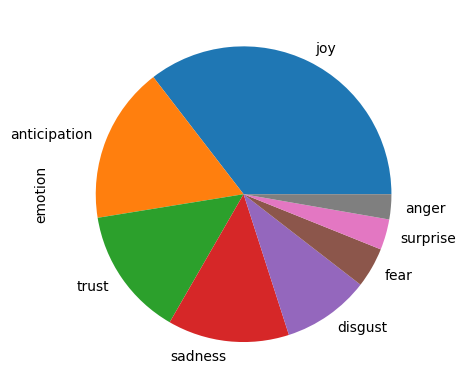

In [4]:
x_train.emotion.value_counts().plot(kind='pie')

joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: emotion, dtype: int64


<AxesSubplot: >

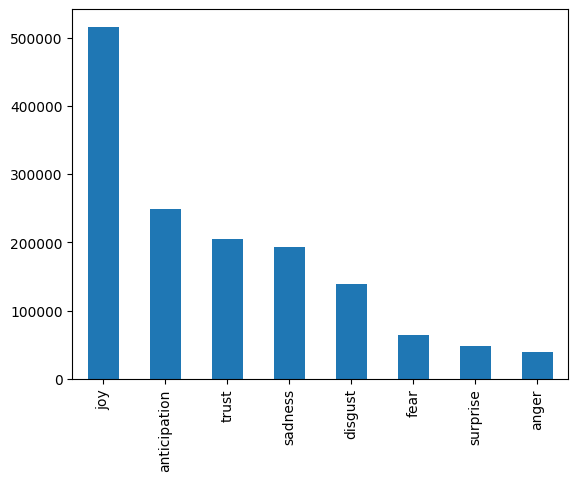

In [5]:
print(x_train.emotion.value_counts())
x_train.emotion.value_counts().plot(kind='bar')

### Data sampling

Since number of `joy` data is so much different than others so we have to do some sampling on the dataset to avoid classification bias

Get only 70,000 samples of data from dataset that has number of records more than 100,000

In [6]:
emotions = x_train.emotion.unique()
train_sampling = pd.DataFrame()
n_sampling = 70000
for e in emotions:
    if x_train[x_train['emotion'] == e].shape[0] > 100000:
        train_sampling = pd.concat([train_sampling, x_train[x_train['emotion'] == e].sample(n=n_sampling, random_state=42)])
    else:
        train_sampling = pd.concat([train_sampling, x_train[x_train['emotion'] == e]])
train_sampling = train_sampling.sample(frac=1, random_state=42)
train_sampling

,tweet_id,text,emotion
942988,0x1d1ade,Tonight’s menu will be <LH> 🎃,fear
420324,0x2d3748,@fabfourfan Says the guy making 47 avatar movies no one asked for. 🙄 <LH>,fear
1433566,0x34bd9f,"The text dialogue b/w Chad & Lawrence had me in tears because that's exactly how me and my best friend are, even down to the gifs <LH>",fear
1441532,0x22116c,Nav said nigga! 😱😱 let's riot like nigga isn't every niggas favorite fucking word. 😂😂😂 #dont #be #sore #over <LH> #shit life is to short.✌️,disgust
77517,0x2afa28,Someone on IG just fucking posted a video explaining how the government and North Korea man-made these hurricanes back2back... <LH>,disgust
...,...,...,...
1399996,0x2a746b,ON THE ☎ WIT MY LAWYERS 📄 N THE MAKING COMING SOON🎈#BLESSED👸#SHEWON📶 FUTURE BRIGHT GOD IS GOOD #BELIEVE#FAITH I KEEP DAT ALWAYS.SHE A 💎💚☺💯,joy
545215,0x255e91,Today I'm <LH> for the rain this morning. ☔️,trust
189547,0x264ea5,ur best friend lowkey envies you... <LH>,sadness
157103,0x1f7d89,"@TheUriGeller I flew RyanAir last year, and Ryan is the name of my nephews classmate. <LH>",fear


Upsampling other data that has less than 70,000 records. Using Imbalance learn library.  
So we will have total data of 560,000 records, with 70,000 records for each emotion

In [7]:
from imblearn.over_sampling import RandomOverSampler

upsampling = RandomOverSampler(random_state=0)
x, y = upsampling.fit_resample(np.array(train_sampling['text']).reshape(-1, 1), np.array(train_sampling['emotion']).reshape(-1, 1))
train_data = pd.DataFrame(list(zip([x[0] for x in x], y)), columns = ['text', 'emotion'])
train_data

,text,emotion
0,Tonight’s menu will be <LH> 🎃,fear
1,@fabfourfan Says the guy making 47 avatar movies no one asked for. 🙄 <LH>,fear
2,"The text dialogue b/w Chad & Lawrence had me in tears because that's exactly how me and my best friend are, even down to the gifs <LH>",fear
3,Nav said nigga! 😱😱 let's riot like nigga isn't every niggas favorite fucking word. 😂😂😂 #dont #be #sore #over <LH> #shit life is to short.✌️,disgust
4,Someone on IG just fucking posted a video explaining how the government and North Korea man-made these hurricanes back2back... <LH>,disgust
...,...,...
559995,"Today, I am officially comfortable knowing that I will never know what happened at #SandyHook and #MandalayBay. <LH> #contrived #chaos",surprise
559996,Some of us were the #misfits. That's why what we do is #different.,surprise
559997,@ajkynwa Oh my it sure was it shook my house car alarms went off the lot <LH>,surprise
559998,Riding Through #NYC Listening To <LH> by @SavannahReMusic 🙌🏾🙌🏾🙌🏾,surprise


#### Result after upsampling

<AxesSubplot: title={'center': 'After Sampling'}>

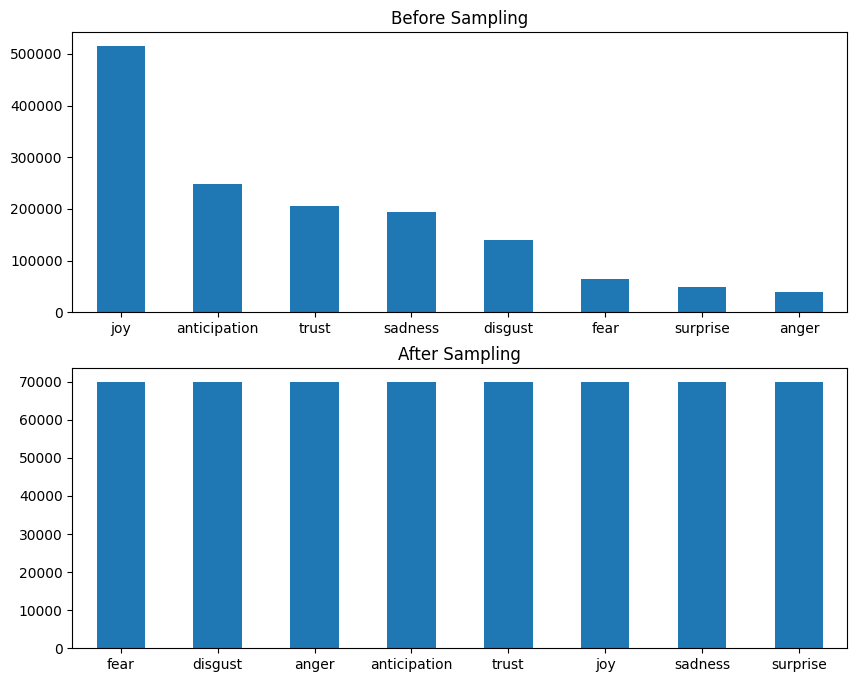

In [85]:
## Plot bar chart
fig, (ax1, ax2) = plt.subplots(2, figsize = (10,8))

x_train.emotion.value_counts().plot(kind='bar',title='Before Sampling',ax=ax1, rot=0)
train_data.emotion.value_counts().plot(kind='bar',title='After Sampling', ax=ax2, rot=0)

<AxesSubplot: ylabel='emotion'>

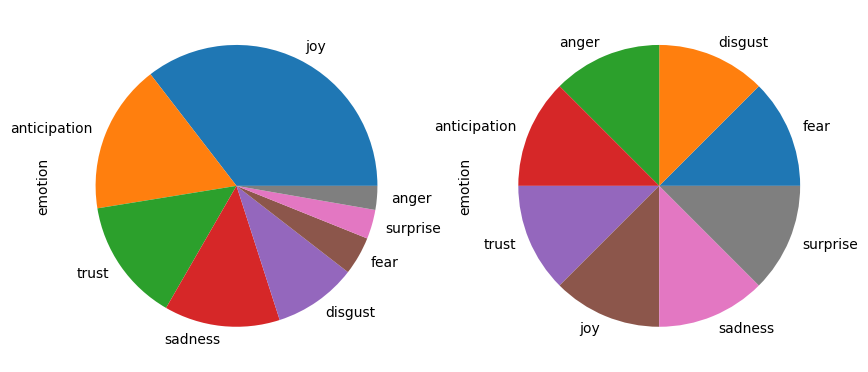

In [76]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,8))
x_train.emotion.value_counts().plot(kind='pie', ax=ax1)
train_data.emotion.value_counts().plot(kind='pie', ax=ax2)

---

## 2. Pre-processing

#### Checking for missing value in dataset

In [86]:
train_data.isnull().sum()

text       0
emotion    0
dtype: int64

#### Checking for duplicate data

In [ ]:
train_data.duplicated().sum()

58250

### Data cleaning
To do da data cleaning I wrote a funtion to clean tweet data ith the following steps:
1. Clean tweet text:
   - Remove hashtag out
   - Remove mention
   - Remove html tag
   - Extend contractions (e.g. I'm -> I am, We're -> We are)
   - Remove punctuations (e.g. !, .., ?)
   - Remove all non character (e.g. *, ^, %)
   - Remove number
   - Fix extra white space between word
   - Fix misspelling word
2. Remove stop words
3. Lemmatize words

In [88]:
import re
import itertools
import contractions
import emoji
import string

def cleaning(data):
    data = re.sub(r'@[\d\w.-_]+', '', data) # remove mentions
    data = re.sub(r'#[\w\S]+', '', data) # remove hashtag
    data = re.sub(r'<.*>', '', data) # remove html tags
    data = re.sub(r'(\w+:\/\/S+)', '', data) # remove URL
    data = contractions.fix(data) # extend contractions
    data = data.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    data = re.sub(r'[^A-Za-z\s]', '', data) # remove non character
    data = re.sub(r'[.{2}]+', ' ', data)
    data = re.sub(r'\d+', '', data) # remove number
    data = emoji.demojize(data, delimiters=(" "," ")) # Replace emoji
    data = re.sub(r'[\s]+', ' ', data) # remove extra space between word
    data = ''.join(''.join(s)[:2] for _, s in itertools.groupby(data)) # fix misspelled word
    data = data.strip()
    data = data.lower()
    return data

In [89]:
from nltk.corpus import stopwords
from nltk import word_tokenize

stop_words = set(stopwords.words('english'))
## Exclude some negative word that might gives more meaning to sentences
exclude = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except','even though', 'yet']
stop_words = [x for x in stop_words if x not in exclude]

def remove_stopwords(text):
    return ' '.join([w for w in word_tokenize(text) if not w in stop_words])


In [90]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

## Tag words to with its part of speech
def lemmatize_sen(text):
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:         
            return wn.NOUN

    lemmatizer = WordNetLemmatizer()
    tag = pos_tag(word_tokenize(text))
    word_tag = list(map(lambda x: (x[0], pos_tagger(x[1])), tag))

    ## Lemmatize words
    return ' '.join([lemmatizer.lemmatize(w, pos=p) for w, p in word_tag])


Start cleaning train and test data

In [91]:
%%time
## Clean train data
train_data['clean_text'] = train_data.text.apply(lambda x: cleaning(x))
train_data['clean_text'] = train_data.clean_text.apply(lambda x: remove_stopwords(x))
train_data['clean_text'] = train_data.clean_text.apply(lambda x: lemmatize_sen(x))

CPU times: user 5min 22s, sys: 3.48 s, total: 5min 26s
Wall time: 5min 28s


In [92]:
%%time
## Clean test data
x_test['clean_text'] = x_test.text.apply(lambda x: cleaning(x))
x_test['clean_text'] = x_test.clean_text.apply(lambda x: remove_stopwords(x))
x_test['clean_text'] = x_test.clean_text.apply(lambda x: lemmatize_sen(x))

CPU times: user 4min 43s, sys: 2.6 s, total: 4min 45s
Wall time: 4min 47s


In [93]:
## Save Cleaned data to file

train_data.to_pickle("datasets/train_data_cleaned.pkl")
x_test.to_pickle("datasets/test_cleaned.pkl")

In [94]:
## Load cleaned train data from file
train_df = pd.read_pickle("datasets/train_data_cleaned.pkl")
train_df

,text,emotion,clean_text
0,Tonight’s menu will be <LH> 🎃,fear,tonight menu
1,@fabfourfan Says the guy making 47 avatar movies no one asked for. 🙄 <LH>,fear,say guy make avatar movie one ask
2,"The text dialogue b/w Chad & Lawrence had me in tears because that's exactly how me and my best friend are, even down to the gifs <LH>",fear,text dialogue bw chad lawrence tear exactly best friend even gifs
3,Nav said nigga! 😱😱 let's riot like nigga isn't every niggas favorite fucking word. 😂😂😂 #dont #be #sore #over <LH> #shit life is to short.✌️,disgust,nav say nigga let u riot like nigga not every nigga favorite fucking word life short
4,Someone on IG just fucking posted a video explaining how the government and North Korea man-made these hurricanes back2back... <LH>,disgust,someone ig fuck post video explaining government north korea manmade hurricane backback
...,...,...,...
559995,"Today, I am officially comfortable knowing that I will never know what happened at #SandyHook and #MandalayBay. <LH> #contrived #chaos",surprise,today officially comfortable know never know happen
559996,Some of us were the #misfits. That's why what we do is #different.,surprise,u
559997,@ajkynwa Oh my it sure was it shook my house car alarms went off the lot <LH>,surprise,oh sure shook house car alarm go lot
559998,Riding Through #NYC Listening To <LH> by @SavannahReMusic 🙌🏾🙌🏾🙌🏾,surprise,rid listen


In [95]:
## Load cleaned test data from file
test_df = pd.read_pickle("datasets/test_cleaned.pkl")
test_df

,tweet_id,text,clean_text
2,0x28b412,"Confident of your obedience, I write to you, knowing that you will do even more than I ask. (Philemon 1:21) 3/4 #bibleverse <LH> <LH>",confident obedience write know even ask philemon
4,0x2de201,"""Trust is not the same as faith. A friend is someone you trust. Putting faith in anyone is a mistake."" ~ Christopher Hitchens <LH> <LH>",trust not faith friend someone trust put faith anyone mistake christopher hitchens
9,0x218443,When do you have enough ? When are you satisfied ? Is you goal really all about money ? #materialism #money #possessions <LH>,enough satisfied goal really money
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #GodsWork <LH>",god wake chase day
33,0x26289a,"In these tough times, who do YOU turn to as your symbol of hope? <LH>",tough time turn symbol hope
...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from the beginning, that we should love one another."" I John 3:11 KJV <LH>",message ye heard begin love one another john kjv
1867529,0x2a980e,"""There is a lad here, which hath five barley loaves, and two small fishes: but what are they among so many?"" ~John 6:9 <LH>",lad hath five barley loaf two small fish but among many john
1867530,0x316b80,When you buy the last 2 tickets remaining for a show and sell it out.. #mixedfeeling <LH> #butimTHATperson,buy last ticket remain show sell
1867531,0x29d0cb,I swear all this hard work gone pay off one day😈💰💸 <LH>,swear hard work go pay one day


### Data segmentation
To evaluate our model, split the train data into 2 sets:
- train set: For training model
- validate set: For evaluating model

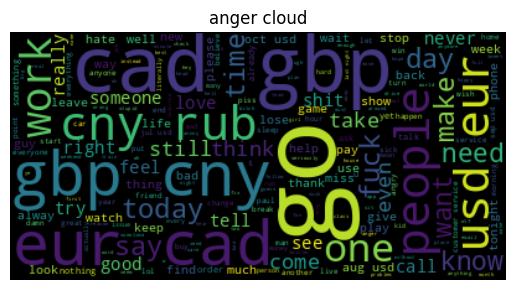

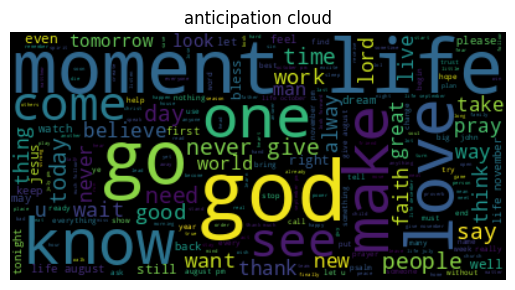

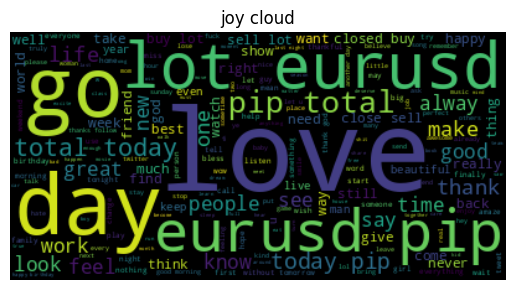

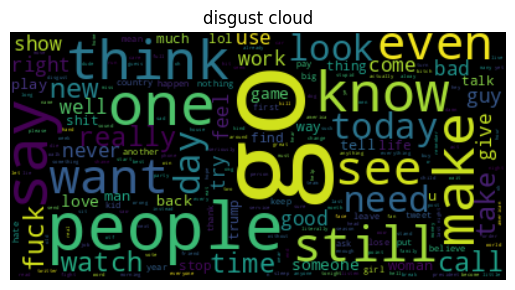

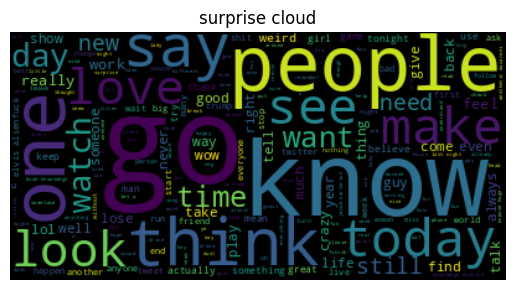

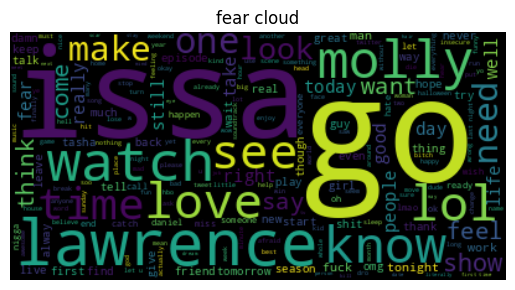

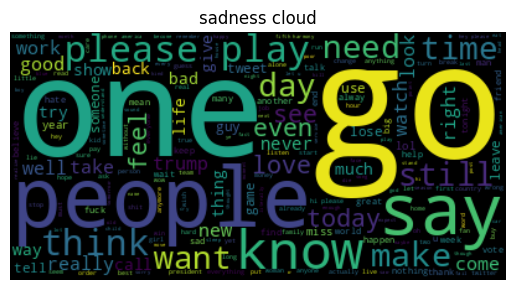

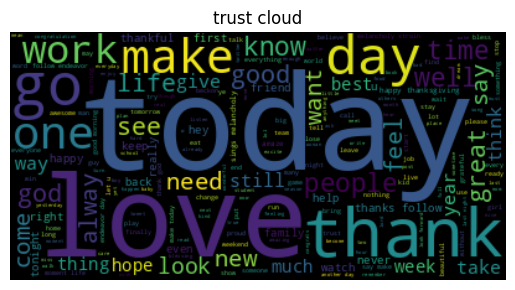

In [96]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_df.clean_text, train_df.emotion, train_size=0.9, shuffle=True, random_state=42)
visual_train = pd.concat([x_train.to_frame(), y_train.to_frame()],axis=1)

for e in visual_train.emotion.unique():
    wordcloud = WordCloud().generate(' '.join(visual_train[visual_train['emotion'] == e].clean_text.values.tolist()))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('{} cloud'.format(e))
    plt.show()

<AxesSubplot: title={'center': 'Validating data'}>

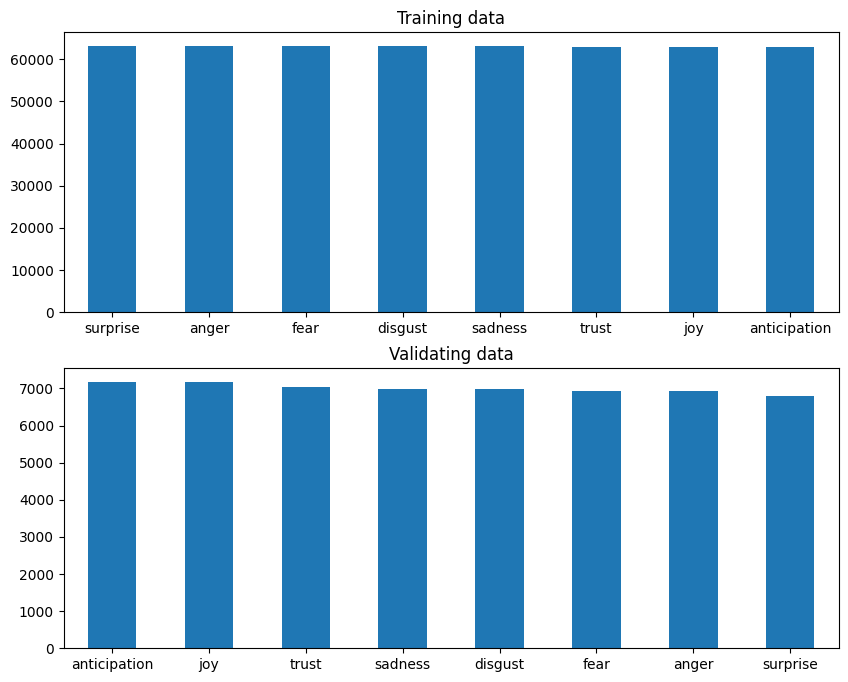

In [102]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(10,8))

y_train.value_counts().plot(kind='bar',ax=ax1, title='Training data', rot=0)
y_val.value_counts().plot(kind='bar',ax=ax2, title='Validating data', rot=0)

<AxesSubplot: title={'center': 'Validating data'}, ylabel='emotion'>

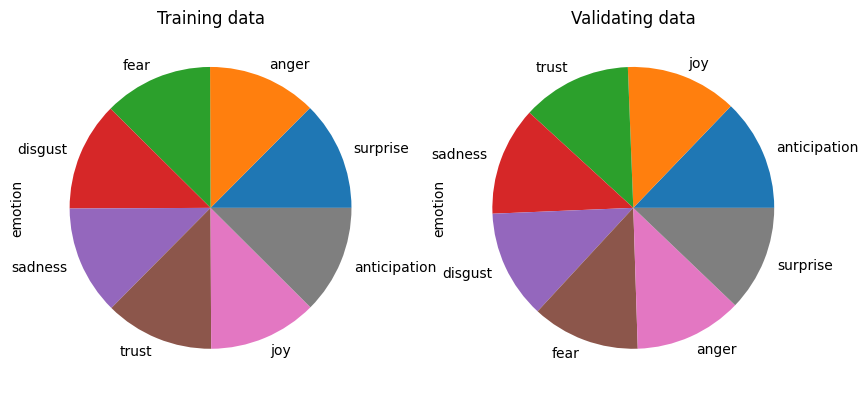

In [103]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,8))

y_train.value_counts().plot(kind='pie',ax=ax1, title='Training data')
y_val.value_counts().plot(kind='pie',ax=ax2, title='Validating data')

---

## 3. Feature extraction

### Bag Of Words(BOW)

Create count vector for train, validate and test dataset

For train dataset

In [104]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

## Create BOW feature
count_vec = CountVectorizer(tokenizer=word_tokenize, stop_words='english')

count_train = count_vec.fit_transform(x_train)
count_train[:10].toarray()

CPU times: user 33.6 s, sys: 38.7 ms, total: 33.6 s
Wall time: 33.8 s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

For validate dataset

In [105]:
%%time
count_val = count_vec.transform(x_val)
count_val[:10].toarray()

CPU times: user 3.75 s, sys: 3 µs, total: 3.75 s
Wall time: 3.77 s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

For test dataset

In [106]:
%%time
count_test = count_vec.transform(test_df.clean_text)
count_test[:10].toarray()

CPU times: user 29.6 s, sys: 11.9 ms, total: 29.7 s
Wall time: 29.8 s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### TF-IDF

Create TFIDF feature for train, validate and test dataset

Calculate TFIDF of training data

In [117]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

## Create TFIDF feature
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words='english')

tfidf_train_feat = tfidf.fit_transform(x_train)
tfidf_train_feat[:10].toarray()

CPU times: user 35.2 s, sys: 60.3 ms, total: 35.3 s
Wall time: 35.4 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Calculate TFIDF of validating data

In [118]:
%%time
tfidf_val_feat = tfidf.transform(x_val)
tfidf_val_feat[:10].toarray()

CPU times: user 3.75 s, sys: 958 µs, total: 3.75 s
Wall time: 3.77 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Calculate TFIDF of testing data

In [119]:
%%time
tfidf_test_feat = tfidf.transform(test_df.clean_text)
tfidf_test_feat[:10].toarray()

CPU times: user 29.8 s, sys: 17 ms, total: 29.8 s
Wall time: 30 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

---

## 4. Train Model & Classification

I have tried to do classification emotion with 5 model as following

1. BOW + Multinomial Naive Bayes
2. BOW + Logistic Regression
3. TFIDF + Multinomial Naive Bayes
4. TFIDF + Logistic Regression
5. RoBERTa



### 4.1 BOW + MultinomialNB 

In [107]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

## Train multinomial naive bayes model
bow_mnb = MultinomialNB()
bow_mnb.fit(count_train,y_train)

## Validate model
validate_bow = bow_mnb.predict(count_val)
print(metrics.classification_report(validate_bow, y_val))

              precision    recall  f1-score   support

       anger       0.49      0.43      0.45      7889
anticipation       0.47      0.44      0.46      7614
     disgust       0.35      0.33      0.34      7401
        fear       0.48      0.46      0.47      7308
         joy       0.26      0.34      0.30      5539
     sadness       0.27      0.33      0.30      5793
    surprise       0.38      0.34      0.36      7478
       trust       0.35      0.35      0.35      6978

    accuracy                           0.38     56000
   macro avg       0.38      0.38      0.38     56000
weighted avg       0.39      0.38      0.38     56000



In [108]:
## Make prediction
bow_emotion = bow_mnb.predict(count_test)
bow_pred = test_df[['tweet_id']]
bow_pred['emotion'] = bow_emotion
bow_pred = bow_pred.rename({'tweet_id':'id'}, axis=1)
bow_pred

/tmp/ipykernel_294023/1903365537.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_pred['emotion'] = bow_emotion


,id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,trust
33,0x26289a,anticipation
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,anticipation
1867530,0x316b80,joy
1867531,0x29d0cb,anger


In [109]:
bow_pred.to_csv('results/bow.csv', index=False)

### 4.2 BOW + Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Train logistic regression model
bow_lr = LogisticRegression(solver='liblinear')
bow_lr.fit(count_train, y_train)

## Validate model
validate_bow_lr = bow_lr.predict(count_val)
print(metrics.classification_report(validate_bow_lr, y_val))

              precision    recall  f1-score   support

       anger       0.51      0.47      0.49      7506
anticipation       0.46      0.45      0.45      7384
     disgust       0.30      0.34      0.32      6189
        fear       0.49      0.48      0.49      7123
         joy       0.36      0.31      0.33      8416
     sadness       0.28      0.32      0.30      6110
    surprise       0.39      0.41      0.40      6416
       trust       0.36      0.37      0.36      6856

    accuracy                           0.39     56000
   macro avg       0.39      0.39      0.39     56000
weighted avg       0.40      0.39      0.40     56000



In [115]:
## Make prediction
bow_lr_emotion = bow_lr.predict(count_test)
bow_lr_pred = test_df[['tweet_id']]
bow_lr_pred['emotion'] = bow_lr_emotion
bow_lr_pred = bow_lr_pred.rename({'tweet_id':'id'}, axis=1)
bow_lr_pred

/tmp/ipykernel_294023/3877588871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_lr_pred['emotion'] = bow_lr_emotion


,id,emotion
2,0x28b412,trust
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,trust
33,0x26289a,trust
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,anticipation
1867530,0x316b80,sadness
1867531,0x29d0cb,anger


In [116]:
bow_lr_pred.to_csv('results/bow_lr.csv', index=False)

### 4.3 TFIDF + MultinomialNB

In [120]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

## Train multinomial naive bayes model
tfidf_mnb = MultinomialNB()
tfidf_mnb.fit(tfidf_train_feat,y_train)

## Validate model
validate = tfidf_mnb.predict(tfidf_val_feat)
print(metrics.classification_report(validate, y_val))

              precision    recall  f1-score   support

       anger       0.50      0.42      0.46      8202
anticipation       0.46      0.45      0.46      7295
     disgust       0.35      0.33      0.34      7407
        fear       0.49      0.46      0.48      7452
         joy       0.27      0.35      0.30      5456
     sadness       0.27      0.33      0.30      5821
    surprise       0.37      0.35      0.36      7265
       trust       0.36      0.35      0.36      7102

    accuracy                           0.38     56000
   macro avg       0.38      0.38      0.38     56000
weighted avg       0.39      0.38      0.39     56000



In [121]:
## Make prediction

tfidf_emotion = tfidf_mnb.predict(tfidf_test_feat)
tfidf_pred = test_df[['tweet_id']]
tfidf_pred['emotion'] = tfidf_emotion
tfidf_pred= tfidf_pred.rename({'tweet_id':'id'}, axis=1)
tfidf_pred

/tmp/ipykernel_294023/2793152666.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_pred['emotion'] = tfidf_emotion


,id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,trust
33,0x26289a,anticipation
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,anticipation
1867530,0x316b80,joy
1867531,0x29d0cb,anger


In [122]:
tfidf_pred.to_csv('results/tfidf.csv', index=False)

### 4.4 TFIDF + Logistic regression

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Train logistic regression model
tfidf_lr = LogisticRegression(solver='liblinear')
tfidf_lr.fit(tfidf_train_feat, y_train)

## Validate model
validate_lr = tfidf_lr.predict(tfidf_val_feat)
print(metrics.classification_report(validate_lr, y_val))

              precision    recall  f1-score   support

       anger       0.51      0.43      0.47      8163
anticipation       0.46      0.46      0.46      7275
     disgust       0.33      0.33      0.33      6998
        fear       0.48      0.50      0.49      6754
         joy       0.34      0.31      0.32      7795
     sadness       0.27      0.32      0.30      5868
    surprise       0.38      0.41      0.39      6310
       trust       0.35      0.36      0.36      6837

    accuracy                           0.39     56000
   macro avg       0.39      0.39      0.39     56000
weighted avg       0.40      0.39      0.39     56000



In [124]:
## Make prediction

tfidf_lr_emotion = tfidf_lr.predict(tfidf_test_feat)
tfidf_lr_pred = test_df[['tweet_id']]
tfidf_lr_pred['emotion'] = tfidf_lr_emotion
tfidf_lr_pred = tfidf_lr_pred.rename({'tweet_id':'id'}, axis=1)
tfidf_lr_pred

/tmp/ipykernel_294023/3952413120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_lr_pred['emotion'] = tfidf_lr_emotion


,id,emotion
2,0x28b412,trust
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,trust
33,0x26289a,anticipation
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,anticipation
1867530,0x316b80,sadness
1867531,0x29d0cb,anger


In [125]:
tfidf_lr_pred.to_csv('results/tfidf_lr.csv', index=False)

### 4.5 RoBERTa

#### Prepare training data
##### Encode label

In [24]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()

## Encode label with one hot encoding
y_train_encoded = label_encoder.fit_transform(y_train.to_numpy().reshape(-1,1)).toarray()
y_val_encoded = label_encoder.fit_transform(y_val.to_numpy().reshape(-1,1)).toarray()

##### Encode Sentences

In [25]:
from transformers import RobertaTokenizerFast

## Load pre-train roberta tokenizer to tokenize sentences
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

## Get number of word from the longest sentence
max_len = max(x_train_df.apply(lambda x: len(x.split(" "))))

## Create function to encode sentences
def roberta_encoder(text):
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        pad_to_max_length=True,
        return_attention_mask=True
    )
    return encoded['input_ids'], encoded['attention_mask']

2022-11-21 04:00:42.469552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Encode train sentences

In [26]:
encoded_train = x_train_df.apply(lambda x: roberta_encoder(x))
train_input = np.array(encoded_train.apply(lambda x: x[0]).tolist())
train_attention_mask = np.array(encoded_train.apply(lambda x: x[1]).tolist())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/supakarn_jari/anaconda3/envs/lab2/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [27]:
train_input, train_attention_mask

(array([[    0,  8198, 32995, ...,     1,     1,     1],
        [    0, 29528,  2761, ...,     1,     1,     1],
        [    0, 13523,   936, ...,     1,     1,     1],
        ...,
        [    0, 18317, 20285, ...,     1,     1,     1],
        [    0,  1610,   571, ...,     1,     1,     1],
        [    0,  2977,  8401, ...,     1,     1,     1]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

Encode validation sentences

In [28]:
encoded_val = x_val.apply(lambda x: roberta_encoder(x))
val_input = np.array(encoded_val.apply(lambda x: x[0]).tolist())
val_attention_mask = np.array(encoded_val.apply(lambda x: x[1]).tolist())

In [29]:
val_input, val_attention_mask

(array([[    0,  3785,  1264, ...,     1,     1,     1],
        [    0,  4128,  9547, ...,     1,     1,     1],
        [    0, 15329,  1761, ...,     1,     1,     1],
        ...,
        [    0, 34375,   295, ...,     1,     1,     1],
        [    0, 10120,  5081, ...,     1,     1,     1],
        [    0, 27363,  1342, ...,     1,     1,     1]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

Encode test sentences

In [30]:
encoded_test = test_df.clean_text.apply(lambda x: roberta_encoder(x))
test_input = np.array(encoded_test.apply(lambda x: x[0]).tolist())
test_attention_mask = np.array(encoded_test.apply(lambda x: x[1]).tolist())

In [31]:
test_input, test_attention_mask

(array([[    0, 17075,  8009, ...,     1,     1,     1],
        [    0, 23170,    45, ...,     1,     1,     1],
        [    0, 38597, 10028, ...,     1,     1,     1],
        ...,
        [    0,  3746,    94, ...,     1,     1,     1],
        [    0,  4184,  4352, ...,     1,     1,     1],
        [    0,  6940,   989, ...,     1,     1,     1]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

#### Train model

In [32]:
from transformers import TFRobertaModel
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import torch
import keras

### Download pre-trained roberta model
roberta = TFRobertaModel.from_pretrained('roberta-base')

## Create model
input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

output = roberta([input_ids,attention_masks])
output = output[1]

output = tf.keras.layers.Dense(len(train_df.emotion.unique()), activation='softmax')(output)
model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

2022-11-21 04:01:58.211514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 04:01:58.212843: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 23,                                            

In [34]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import callbacks

## Create checkpoint
modelpath = "models/my_roberta.h5"
checkpoint = ModelCheckpoint(modelpath, monitor='loss', verbose=1, save_best_only=True, mode='min')

## Log training
csv_logger = CSVLogger('training_log.csv')

callbacks_list = [csv_logger, checkpoint]

## Train model
training = model.fit([train_input,train_attention_mask], y_train_encoded, validation_data=([val_input,val_attention_mask], y_val_encoded), epochs=3,batch_size=100, callbacks=callbacks_list)

Epoch 1/3


2022-11-21 04:02:11.809760: E tensorflow/core/framework/node_def_util.cc:675] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node model/tf_roberta_model/roberta/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}


4480/4480 [==============================] - ETA: 0s - loss: 1.7018 - accuracy: 0.3556

2022-11-21 11:07:21.687352: E tensorflow/core/framework/node_def_util.cc:675] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node model/tf_roberta_model/roberta/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}



Epoch 1: loss improved from inf to 1.70184, saving model to models/my_roberta.h5
4480/4480 [==============================] - 27828s 6s/step - loss: 1.7018 - accuracy: 0.3556 - val_loss: 1.6169 - val_accuracy: 0.3949
Epoch 2/3
4480/4480 [==============================] - ETA: 0s - loss: 1.5939 - accuracy: 0.4031
Epoch 2: loss improved from 1.70184 to 1.59386, saving model to models/my_roberta.h5
4480/4480 [==============================] - 27403s 6s/step - loss: 1.5939 - accuracy: 0.4031 - val_loss: 1.5870 - val_accuracy: 0.4124
Epoch 3/3
4480/4480 [==============================] - ETA: 0s - loss: 1.5324 - accuracy: 0.4296
Epoch 3: loss improved from 1.59386 to 1.53236, saving model to models/my_roberta.h5
4480/4480 [==============================] - 27205s 6s/step - loss: 1.5324 - accuracy: 0.4296 - val_loss: 1.5622 - val_accuracy: 0.4241


#### Continue train the model

In [68]:
## Continue training
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import callbacks

## Load model
retrain_model = keras.models.load_model(modelpath, custom_objects={'TFRobertaModel': roberta})

## Create checkpoint
modelpath = "models/my_roberta.h5"
checkpoint = ModelCheckpoint(modelpath, monitor='loss', verbose=1, save_best_only=True, mode='min')

## Log training
csv_logger = CSVLogger('training_log_retrain.csv')

## Auto stop before model overfitted
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

callbacks_list = [csv_logger, earlystopping, checkpoint]

np.testing.assert_allclose(
    model.predict([test_input, test_attention_mask]), retrain_model.predict([test_input, test_attention_mask])
)

## Comment this out to avoid triggerring training process
## Training took around 10 hrs per epoch
history = retrain_model.fit([train_input,train_attention_mask], y_train_encoded, validation_data=([val_input,val_attention_mask], y_val_encoded), epochs=5,batch_size=100, callbacks=callbacks_list)

12875/12875 [==============================] - 9027s 701ms/step
Epoch 1/5


2022-11-23 06:03:16.898072: E tensorflow/core/framework/node_def_util.cc:675] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node model/tf_roberta_model_3/roberta/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}


4480/4480 [==============================] - ETA: 0s - loss: 1.4746 - accuracy: 0.4546

2022-11-23 13:02:36.270176: E tensorflow/core/framework/node_def_util.cc:675] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node model/tf_roberta_model_3/roberta/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}



Epoch 1: loss improved from inf to 1.47457, saving model to models/my_roberta.h5
4480/4480 [==============================] - 27478s 6s/step - loss: 1.4746 - accuracy: 0.4546 - val_loss: 1.5494 - val_accuracy: 0.4322
Epoch 2/5
4480/4480 [==============================] - ETA: 0s - loss: 1.4135 - accuracy: 0.4778
Epoch 2: loss improved from 1.47457 to 1.41345, saving model to models/my_roberta.h5
4480/4480 [==============================] - 27380s 6s/step - loss: 1.4135 - accuracy: 0.4778 - val_loss: 1.5506 - val_accuracy: 0.4406
Epoch 3/5
4480/4480 [==============================] - ETA: 0s - loss: 1.3529 - accuracy: 0.5021
Epoch 3: loss improved from 1.41345 to 1.35288, saving model to models/my_roberta.h5
4480/4480 [==============================] - 27309s 6s/step - loss: 1.3529 - accuracy: 0.5021 - val_loss: 1.5602 - val_accuracy: 0.4477
Epoch 4/5
4480/4480 [==============================] - ETA: 0s - loss: 1.2905 - accuracy: 0.5268
Epoch 4: loss improved from 1.35288 to 1.29051, s

##### Visualize accuracy & loss

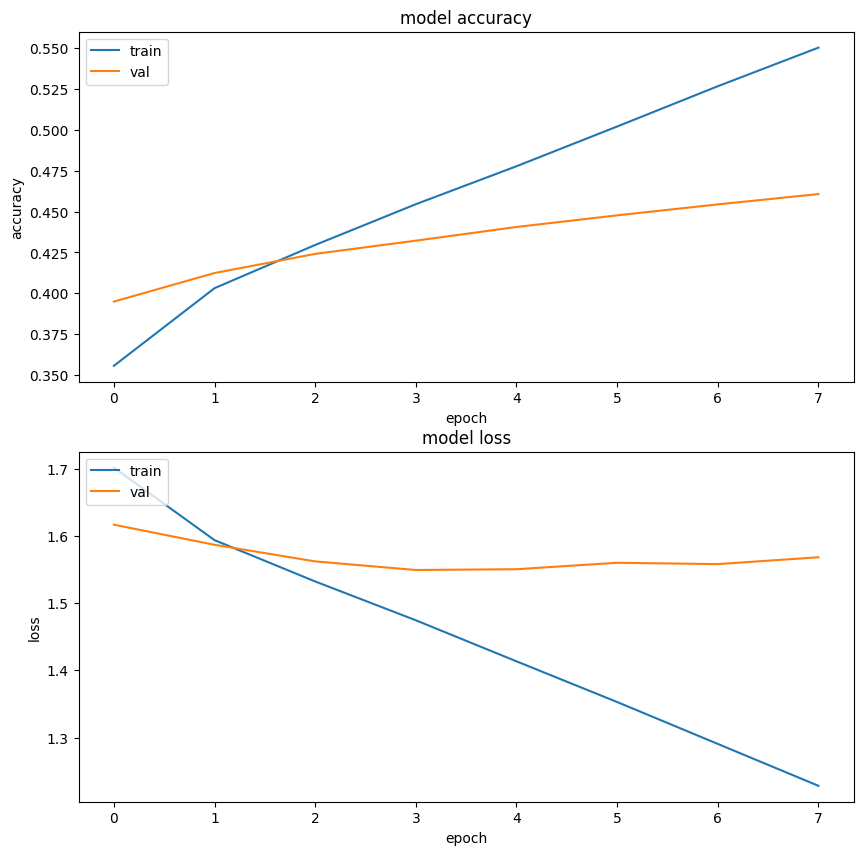

In [81]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(10,10))

first_train = pd.read_csv('training_log.csv')
second_train = pd.read_csv('training_log_retrain.csv')

history = pd.concat([first_train, second_train], ignore_index=True)
history
## Plot model accuray
ax1.plot(history['accuracy'])
ax1.plot(history['val_accuracy'])
ax1.title.set_text('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

## Plot model loss
ax2.plot(history['loss'])
ax2.plot(history['val_loss'])
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

#### Make prediction

In [38]:
## Load model
from tensorflow import keras

model = keras.models.load_model(modelpath, custom_objects={'TFRobertaModel': roberta})

In [39]:
roberta_pred = model.predict([test_input, test_attention_mask])

12875/12875 [==============================] - 8787s 682ms/step


In [40]:
roberta_pred

array([[8.81072076e-04, 9.41209018e-01, 7.54724548e-04, ...,
        1.23820023e-03, 1.37272780e-03, 3.92557159e-02],
       [6.20586425e-03, 3.45409095e-01, 3.89158679e-03, ...,
        4.28618910e-03, 5.25351474e-03, 6.07903957e-01],
       [9.39811245e-02, 1.20930299e-01, 1.03482358e-01, ...,
        2.42737696e-01, 1.09162234e-01, 1.72344923e-01],
       ...,
       [6.17422700e-01, 4.79051135e-02, 8.05715397e-02, ...,
        1.98659629e-01, 1.29178371e-02, 9.12730861e-03],
       [6.47450626e-01, 9.59594622e-02, 2.67772824e-02, ...,
        1.33099124e-01, 7.60378782e-03, 3.04932054e-02],
       [3.66971523e-01, 3.33920829e-02, 8.26921090e-02, ...,
        1.64331689e-01, 2.52560854e-01, 1.00154076e-02]], dtype=float32)

In [42]:
decode = label_encoder.inverse_transform(roberta_pred)

In [43]:
result = test_df[['tweet_id']]
result['emotion'] = decode
result = result.rename({'tweet_id':'id'},axis=1)
result

/tmp/ipykernel_229926/2033903835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['emotion'] = decode


,id,emotion
2,0x28b412,anticipation
4,0x2de201,trust
9,0x218443,sadness
30,0x2939d5,trust
33,0x26289a,trust
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,anticipation
1867530,0x316b80,anger
1867531,0x29d0cb,anger


In [44]:
result.to_csv('results/roberta.csv', index=False)

---

## 5. Conclusion
### Findings
1. The majority data is belong to `joy` lebel
2. Cleaning twitter post is difficult because there is no fix pattern some post put hashtag as context in sentence (e.g. I am very #happy), so when I delete hashtag it will delete some word that is important.
3. From all the model I have tried RoBERTa gives me the best result(score around 0.36xx).
4. RoBERTa model requires a lot of time to train (with 448,000 input data it took around 8 hours/epoch).

### Things I want to try
1. I want to try using other models such as KNN, RNN
2. Try other sentence embedding technique such as Doc2Vec, sentence transformer
2. Giving more epoch for RoBERTa model to learn

### Things I want to imporve
1. Increase training size
2. Cleaning data more neatly